https://fleuret.org/dlc/materials/dlc-slides-7-4-VAE.pdf (ref)

In [ ]:
import torch
from torch import nn 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset
from torch.utils.data import default_collate, DataLoader
import matplotlib.pyplot as plt
import math
import logging
import wandb
import os
logging.basicConfig(level=logging.ERROR)

In [ ]:
def transform(b):
    b['image'] = [TF.to_tensor(o) for o in b['image']]
    return b

def collate_dict(b):
    c = default_collate(b)
    return (c['image'], c['label'])

bs = 1024

data = load_dataset('mnist')
train_data, valid_data = data['train'].with_transform(transform), data['test'].with_transform(transform)
train_dl = DataLoader(train_data, batch_size=bs, shuffle=True, collate_fn=collate_dict) 
valid_dl = DataLoader(valid_data, batch_size=bs*2, shuffle=False, collate_fn=collate_dict)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset mnist downloaded and prepared to /root/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
len(train_dl),len(valid_dl)

(59, 5)

torch.Size([1024, 1, 28, 28]) torch.Size([1024])


tensor(5)

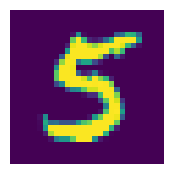

In [ ]:
xb,yb = next(iter(train_dl))
print(xb.shape, yb.shape)
plt.figure(figsize=(2, 2))
plt.imshow(xb[0].permute(1,2,0));
plt.axis('off');yb[0]

In [ ]:
class VAE(nn.Module):
    def __init__(self, nb_channels, latent_dim):
        super().__init__() 
    
        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=1),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True), 
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True), 
            nn.Conv2d(nb_channels, latent_dim*2, kernel_size=4),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, nb_channels, kernel_size=4),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),
            nn.Sigmoid()
        )  
    
    def encode(self, x):
        out = self.encoder(x).view(x.shape[0], 2, -1)
        mu,log_var = out[:,0],out[:,1]
        return mu,log_var
    
    def sample_gaussian(self, mu, log_var):
        std = log_var.mul(0.5).exp()
        return mu + torch.randn(mu.size(), device=mu.device) * std
    
    def decode(self, z):
        mu_hat = self.decoder(z.view(z.shape[0], -1, 1, 1))
        return mu_hat,mu_hat.new_zeros(mu_hat.size())
    
    def log_p_gaussian(self, x, mu_hat, log_var_hat):
        mu_hat,log_var_hat,x = mu_hat.flatten(1),log_var_hat.flatten(1),x.flatten(1)
        var_hat = log_var_hat.exp()
        return -0.5*(((x-mu_hat).pow(2)/var_hat) + log_var_hat + math.log(2*math.pi)).sum(1)     
    
    def dkl(self, dist_a, dist_b):
        mu_a,log_var_a = dist_a[0].flatten(1),dist_a[1].flatten(1)
        mu_b,log_var_b = dist_b[0].flatten(1),dist_b[1].flatten(1)
        var_a = log_var_a.exp()
        var_b = log_var_b.exp()
        return  0.5 * (log_var_b - log_var_a - 1 + (mu_a - mu_b).pow(2) / var_b + var_a / var_b).sum(1)
     
    def forward(self, x):
        mu,log_var = self.encode(x)
        
        z = self.sample_gaussian(mu, log_var)
        
        mu_hat,log_var_hat = self.decode(z)
        
        log_p_given_z = self.log_p_gaussian(x, mu_hat, log_var_hat)
        
        z_prior = (torch.zeros_like(mu), torch.zeros_like(log_var))
        dkl_q_vs_z = self.dkl((mu, log_var), z_prior)
        
        loss = -(log_p_given_z-dkl_q_vs_z).mean()
        
        with torch.no_grad():
            self.kl_loss = dkl_q_vs_z.mean().item()
            self.reconst_loss = -log_p_given_z.mean().item()
        
        return loss

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cuda


In [ ]:
m = VAE(nb_channels=8, latent_dim=32).to(device)
o = m(xb.to(device))
o

tensor(816.8900, device='cuda:0', grad_fn=<NegBackward0>)

In [ ]:
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params = f"{total_params / 1_000_000:.2f}M"
print(f"total number of parameters: {total_params}")

total number of parameters: 0.02M


In [ ]:
model = VAE(nb_channels=16, latent_dim=32).to(device)
lr = 1e-3
epochs = 20
opt = torch.optim.AdamW(model.parameters(),lr)


wandb.init(
    project="variational_autoencoder_fleuret",
    config={
      "batch_size": bs,
      "learning_rate": lr,
      "architecture": "CNN",
      "dataset": "MNIST",
      "epochs": epochs,
      "total_params": total_params,
      "model":model
    }
)

for epoch in range(epochs):
    for xb,yb in train_dl:
        xb = xb.to(device)
        loss = model(xb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        with torch.no_grad():
            wandb.log({"loss": round(loss.item(), 4),
                     "reconstruct_loss": round(model.reconst_loss, 4),
                     "kl_loss": round(model.kl_loss, 4)})
            orginial_img = [wandb.Image(o, caption="original") for o in xb.detach().cpu()[:5]]
            
            mu,log_var = model.encode(xb.to(device)) 
            zb = model.sample_gaussian(mu, log_var)
            recon_xb = model.decode(zb.view(zb.shape[0], -1, 1, 1))
            recon_xb = recon_xb[0].detach().cpu()
            reconstruct = [wandb.Image(o, caption="reconstruct") for o in recon_xb[:5]]
            
            
            samples_xb = torch.randn_like(xb)
            mu,log_var = model.encode(samples_xb.to(device)) 
            zb = model.sample_gaussian(mu, log_var)
            generate_xb = model.decode(zb.view(zb.shape[0], -1, 1, 1))[0]
            generate_xb = generate_xb.detach().cpu()
            
            generated = [wandb.Image(o, caption="generated_sample")\
                                for o in generate_xb.detach().cpu()[:5]]
            
            wandb.log({"original": orginial_img, 
                       "reconstruct": reconstruct, 'generated':generated})
        
    print(f'loss:{loss.item():.4f}')
    
wandb.finish()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


loss:747.4678


wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: Network error resolved after 0:00:01.259011, resuming normal operation.


loss:745.2034
loss:743.3293


wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request


loss:742.2320


wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: Network error resolved after 0:00:03.573112, resuming normal operation.


loss:741.6351


wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request


loss:740.8102
loss:741.1094
loss:740.2599
loss:740.6353
loss:740.2573
loss:739.9802
loss:740.3499
loss:740.1296


wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request


loss:740.0618


wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request


loss:740.2981
loss:739.9223
loss:739.8513
loss:739.6865
loss:740.1428
loss:739.9608


kl_loss,▁▁▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█████████████
loss,█▇▆▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruct_loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_loss,6.3905
loss,739.9608
reconstruct_loss,733.5702


In [ ]:
with torch.no_grad():
    xvb,yvb = next(iter(valid_dl))
    mu,log_var = model.encode(xvb.to(device)) 
    zb = model.sample_gaussian(mu, log_var)
    recon_xb = model.decode(zb.view(zb.shape[0], -1, 1, 1))
    recon_xb = recon_xb[0].detach().cpu()
recon_xb.shape

torch.Size([2048, 1, 28, 28])

tensor(7)

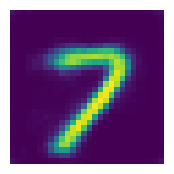

In [ ]:

plt.figure(figsize=(2, 2))
plt.imshow(recon_xb[0].permute(1,2,0));
plt.axis('off');yvb[0]

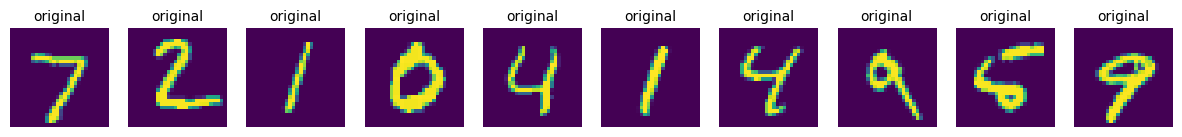

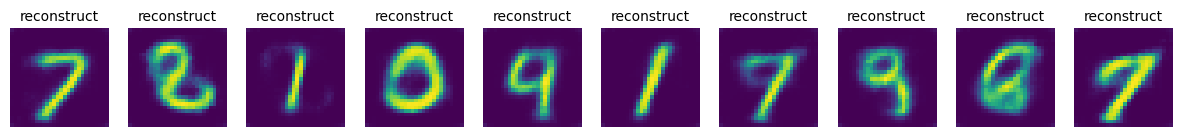

In [ ]:
plot_sz = 10
_,axs = plt.subplots(1, plot_sz, figsize=(15, 15))
for im,ax in zip(xvb,axs.flat):
  ax.imshow(im.permute(1,2,0).detach().cpu());
  ax.axis('off')
  ax.set_title('original', fontsize=10)

_,axs = plt.subplots(1, plot_sz, figsize=(15, 15))
for im,ax in zip(recon_xb,axs.flat):
  ax.imshow(im.permute(1,2,0).detach().cpu());
  ax.axis('off')
  ax.set_title('reconstruct', fontsize=10)

In [ ]:
with torch.no_grad():
    samples_xb = torch.randn_like(xvb)
    mu,log_var = model.encode(samples_xb.to(device)) 
    zb = model.sample_gaussian(mu, log_var)
    generate_xb = model.decode(zb.view(zb.shape[0], -1, 1, 1))[0]
    generate_xb = generate_xb.detach().cpu()
generate_xb.shape

torch.Size([2048, 1, 28, 28])

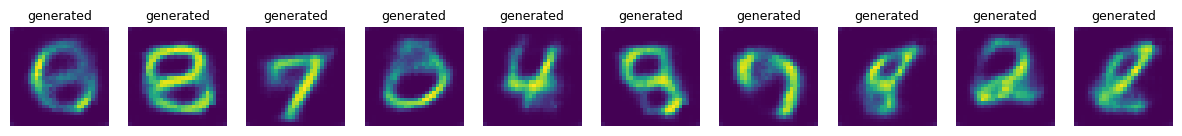

In [ ]:
_,axs = plt.subplots(1, 10, figsize=(15, 15))
for im,ax in zip(generate_xb,axs.flat):
  ax.imshow(im.permute(1,2,0).detach().cpu());
  ax.axis('off')
  ax.set_title('generated', fontsize=9)